In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing import image


In [17]:
# Download kaggle dataset using kaggle API
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge -f icml_face_data.csv
! unzip '../content/icml_face_data.csv.zip'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 92% 89.0M/96.6M [00:02<00:00, 37.1MB/s]
100% 96.6M/96.6M [00:02<00:00, 35.9MB/s]
Archive:  ../content/icml_face_data.csv.zip
  inflating: icml_face_data.csv      


In [18]:
# Load dataset using pandas library
data = pd.read_csv('../content/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


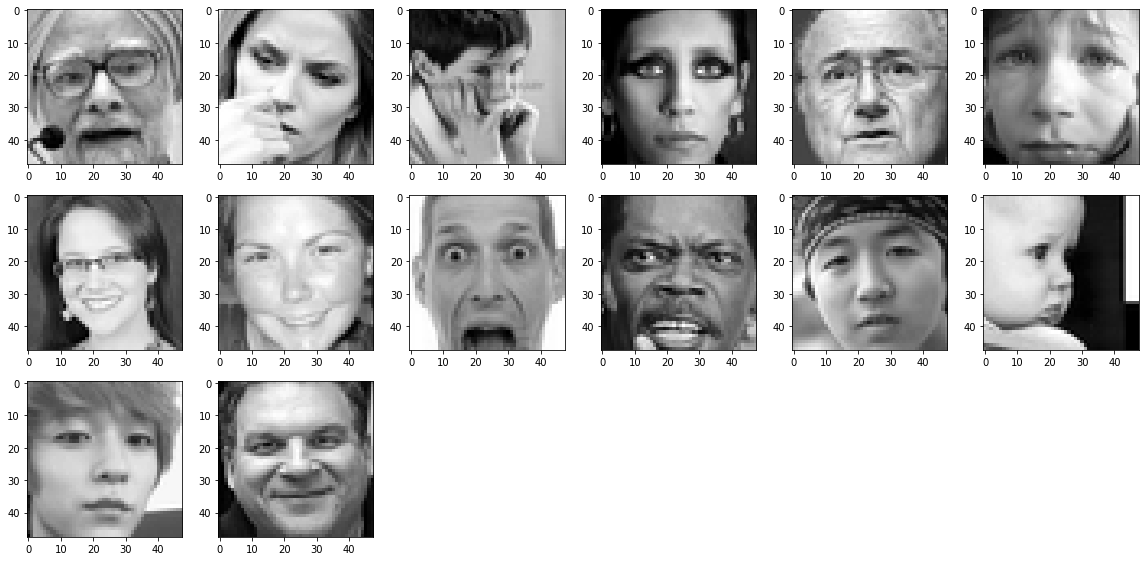

In [ ]:
# Visualize some images from dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(1,15):
  plt.subplot(6,6,i)
  img=np.array(data[' pixels'].loc[i].split(" ")).reshape(48,48).astype('float32')
  plt.imshow(img,cmap='gray')
plt.show()

In [10]:
# Extract the image and the label from the dataframe
image = data[' pixels']
label = data['emotion']

In [ ]:
# Build image preprocessing function
def preprocess_image(image):
  images = []
  for i in range(len(image)):
    img = np.fromstring(image[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)

 

  return X

In [11]:
# Use RandomOverSampler to perform random over-sampling
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(image.values.reshape(-1,1), label)

X_over_series = pd.Series(X_over.flatten())

In [ ]:
# Preprocess the images
X = preprocess_image(X_over_series)
Y = Y_over
Y = Y_over.values.reshape(Y.shape[0],1)

# Split the dataset into train and test (90% training, 10% testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [ ]:
# Build tensorflow model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
classes = 7

model = tf.keras.models.Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3),   input_shape =(48,48,1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), ))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
    

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.6))
    
model.add(Dense(classes, activation='softmax'))

In [ ]:
# Compile the model 
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Convert the label into one hot encode
y_train = to_categorical(Y_train, num_classes=7)

y_test = to_categorical(Y_test, num_classes=7)

In [ ]:
# Use ModelCheckpoint as callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = ModelCheckpoint('model_fer_laras.h5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [ ]:
model.fit(X_train,y_train,epochs=35,validation_data=(X_test,y_test),callbacks=[callbacks])

Epoch 1/35
1770/1770 [==============================] - ETA: 0s - loss: 1.7310 - accuracy: 0.3227
Epoch 1: val_accuracy improved from -inf to 0.44049, saving model to model_fer_laras.h5
1770/1770 [==============================] - 35s 13ms/step - loss: 1.7310 - accuracy: 0.3227 - val_loss: 1.4659 - val_accuracy: 0.4405
Epoch 2/35
1768/1770 [============================>.] - ETA: 0s - loss: 1.3822 - accuracy: 0.4695
Epoch 2: val_accuracy improved from 0.44049 to 0.54934, saving model to model_fer_laras.h5
1770/1770 [==============================] - 25s 14ms/step - loss: 1.3822 - accuracy: 0.4695 - val_loss: 1.1827 - val_accuracy: 0.5493
Epoch 3/35
1769/1770 [============================>.] - ETA: 0s - loss: 1.2019 - accuracy: 0.5382
Epoch 3: val_accuracy improved from 0.54934 to 0.59717, saving model to model_fer_laras.h5
1770/1770 [==============================] - 26s 15ms/step - loss: 1.2019 - accuracy: 0.5382 - val_loss: 1.0599 - val_accuracy: 0.5972
Epoch 4/35
1769/1770 [=========

In [ ]:
# Convert the model to tflite format
import pathlib

model = tf.keras.models.load_model('model_fer_laras.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('model_fer_laras.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpttlirvky/assets


2759032

In [ ]:
# Map the integer label into the corresponding expression
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

The predicted emotion is : Fear


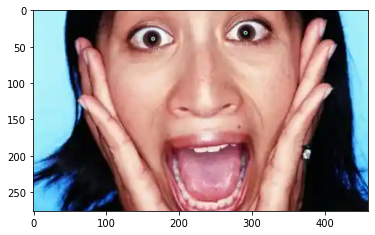

In [ ]:
# Test the model with unseen image
img_path = 'fear.webp'
img = image.load_img(img_path, color_mode = "grayscale", target_size=(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

In [30]:
new_images = data[data[' Usage'].isin(['PublicTest','PrivateTest'])][' pixels']
new_labels = data[data[' Usage'].isin(['PublicTest','PrivateTest'])]['emotion']

In [38]:
new_images.reset_index(drop=True,inplace=True)

In [41]:
new_labels.reset_index(drop=True,inplace=True)

In [34]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)

 

  return X

In [39]:
test_images = preprocess_pixels(new_images)

In [43]:
model = tf.keras.models.load_model('model_fer_laras.h5')
pred = model.predict(test_images)

In [44]:
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

pred_class_train = get_class(pred)

In [45]:
pred_class_train

array([[0.],
       [1.],
       [4.],
       ...,
       [0.],
       [3.],
       [2.]])

In [60]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(new_labels,pred_class_train)

In [47]:
cm

array([[ 930,    1,    1,    9,   11,    2,    4],
       [   0,  111,    0,    0,    0,    0,    0],
       [  12,    0,  967,    7,   26,    8,    4],
       [   4,    0,    9, 1741,    9,    5,    6],
       [   7,    0,   13,   13, 1195,    4,   15],
       [   2,    0,   10,    5,    0,  814,    0],
       [  10,    0,    5,   15,   33,    5, 1165]])

In [48]:
cm_df = pd.DataFrame(cm,
                     index = ['Angry',  'Disgust',  'Fear',  'Happiness',  'Sad', 'Surprise', 'Neutral'], 
                     columns = ['Angry',  'Disgust',  'Fear',  'Happiness',  'Sad', 'Surprise', 'Neutral'])

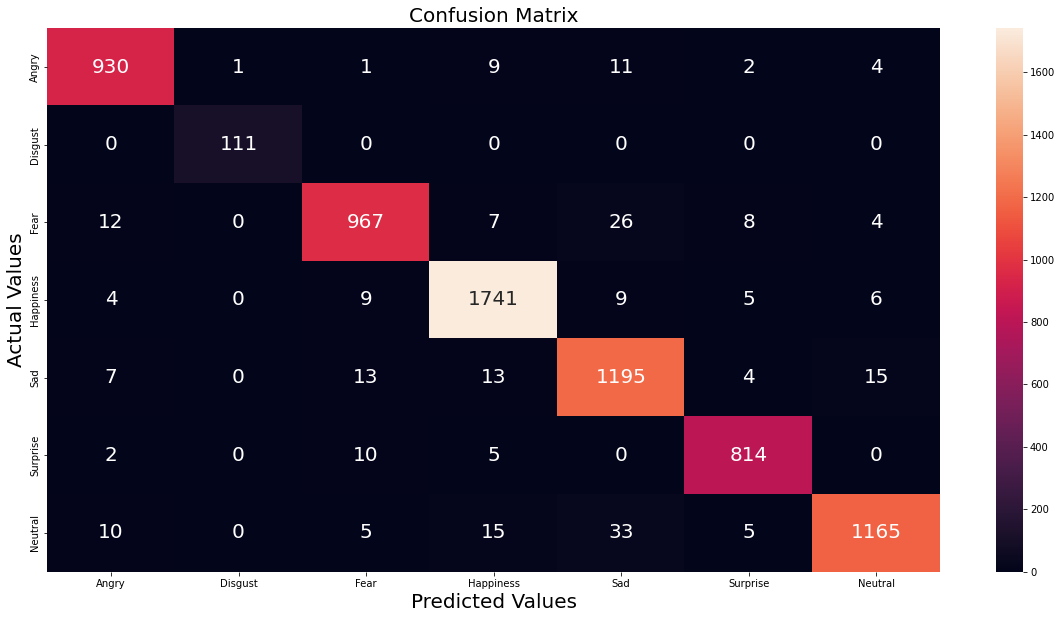

In [58]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(cm_df, annot=True, fmt='d', annot_kws={'size':20})
plt.title('Confusion Matrix',fontsize=20)
plt.ylabel('Actual Values',fontsize=20)
plt.xlabel('Predicted Values',fontsize=20)
plt.show()


In [ ]:
!pip install tflite-support-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.5 MB 1.4 MB/s 
     |████████████████████████████████| 1.0 MB 26.7 MB/s 
     |████████████████████████████████| 213 kB 56.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "model_fer_laras.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "labels_FER.txt"
_SAVE_TO_PATH = "model_fer_laras_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba